# Projet IA : Vérification de la véracité des informations concernant COVID19. 

## Importation des dépendances 

In [1]:

#Importation des librairies

import numpy as np
import pandas as pd
# Visualisation
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from tqdm import tqdm, tqdm_notebook # show progress bar
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Natural Language Toolkit
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer


import re
import string
import random

from sklearn.model_selection import train_test_split


# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split


from sklearn.metrics import classification_report


In [2]:
# importation du dataset
df = pd.read_excel("Data-FakeRealCOVID.xlsx", header=0)

## Exploration du Dataset

In [3]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [4]:
df.columns

Index(['id', 'tweet', 'label'], dtype='object')

In [5]:
print("lenght : ",len(df))
print("size :",df.size)
print("shape : ",df.shape)

lenght :  6420
size : 19260
shape :  (6420, 3)


In [6]:
df.info(verbose  = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Columns: 3 entries, id to label
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [7]:
df.dtypes

id        int64
tweet    object
label    object
dtype: object

In [8]:
#Vérification des données manquantes
df.columns[df.isnull().any()]

Index([], dtype='object')

On a pas de données manquantes

In [9]:
# voir les valeurs possible de la collone label
df['label'].unique()

array(['real', 'fake'], dtype=object)

In [10]:
df['label'].nunique()


2

In [11]:
output_notebook()

Loading BokehJS ...

In [12]:
# Visualisation 

label = df.groupby('label').count()
idx = label.index.tolist()
values= label['tweet'].tolist()

In [13]:
p = figure(x_range=idx, title="Distribution of data",
           toolbar_location=None, tools="")

p.vbar(x=idx, top=values, width=0.9)

p.xgrid.grid_line_color = None


show(p)

## Prétraitement des données

In [14]:
data=df[['tweet','label']]


In [15]:
# On remplace les labels par des données binaire
data['label'] = data['label'].replace('real',1)
data['label'] = data['label'].replace('fake',0)


<ipython-input-15-85451820ced1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace('real',1)
<ipython-input-15-85451820ced1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace('fake',0)


In [16]:
data['label'].unique()

array([1, 0], dtype=int64)

In [17]:
# on crée un dataset tel que les données sont bien séparés
data_real = data[data['label'] == 1]
data_fake = data[data['label'] == 0]
dataset = pd.concat([data_real, data_fake])

In [18]:
dataset['tweetsave']=dataset['tweet']

In [19]:
# Fonctions pour nettoyage des données

## supprimer les emojis 
def deEmojify(text):
    return text.encode("ascii", "ignore").decode()
## séparer les hashtags en des mots 
def clean_hash(text):
    s = ""
    for word in str(text).split():
        if word.startswith("#"):
            word=  " ".join([a for a in re.split('([A-Z][a-z]+)', word) if a])
        s+= word+' '
    return s
## supprimer les mentions 
def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)
## supprimer les urls 
def clean_url(text):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
## supprimer la ponctuation 
punctuations = string.punctuation
def clean_punctuation(text):
    trs = str.maketrans('', '', punctuations)
    return text.translate(trs)
## supprimer les nombres 
def clean_numbers(text):
    return re.sub('[0-9]+', '', text)

In [20]:
## supprimer les stop words 
# géneration de la liste des "mots vide"(stopwords) avec nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords= stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\botai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
print(*stopwords)

i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't


In [22]:
STOPWORDS= set(stopwords)

In [23]:
## supprimer les stopwords 
def clean_stopword(text):
    s = ""
    for word in str(text).split():
        if word not in STOPWORDS:
             s+=word+" "
    return s

In [24]:
# on supprime les mots contenant une seule lettre
def clean_shortwords(text):
    s=""
    for word in str(text).split():
        if len(word) > 1:
            s+=word+" "
    return s

In [25]:
dataset['tweet'] = dataset['tweet'].apply(lambda text: deEmojify(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_hash(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: remove_mentions(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_url(text))
dataset['tweet'] = dataset['tweet'].str.lower()
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_stopword(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_punctuation(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_numbers(text))
dataset['tweet'] = dataset['tweet'].apply(lambda text: clean_shortwords(text))
dataset


,tweet,label,tweetsave
0,cdc currently reports deaths general discrepan...,1,The CDC currently reports 99031 deaths. In gen...
1,states reported deaths small rise last tuesday...,1,States reported 1121 deaths a small rise from ...
3,india fights corona covid testing laboratories...,1,#IndiaFightsCorona: We have 1524 #COVID testin...
4,populous states generate large case counts loo...,1,Populous states can generate large case counts...
5,covid act found on average person illinois cov...,1,"Covid Act Now found ""on average each person in..."
...,...,...,...
6413,states like new york illinois california vocal...,0,States like New York Illinois and California h...
6415,tiger tested positive covid please stay away p...,0,A tiger tested positive for COVID-19 please st...
6416,autopsies prove covid is blood clot pneumonia ...,0,???Autopsies prove that COVID-19 is??� a blood...
6417,post claims covid vaccine already developed ca...,0,_A post claims a COVID-19 vaccine has already ...


### Tokenisation des tweets avec NLTK

In [26]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\botai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\botai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
dataset['tweet_tokenized'] = dataset['tweet'].apply(nltk.word_tokenize)
dataset['tweet_tokenized'].head()

0    [cdc, currently, reports, deaths, general, dis...
1    [states, reported, deaths, small, rise, last, ...
3    [india, fights, corona, covid, testing, labora...
4    [populous, states, generate, large, case, coun...
5    [covid, act, found, on, average, person, illin...
Name: tweet_tokenized, dtype: object

### Stemming avec nltk
 processus de réduction d'un mot à un ou plusieurs racines.

In [28]:
ps = PorterStemmer()

def stemming(token):
    l=[]
    for e in token:
        l.append(ps.stem(e))
    return l
dataset['tweet_tokenized']= dataset['tweet_tokenized'].apply(lambda t: stemming(t))
dataset['tweet_tokenized'].head()

0    [cdc, current, report, death, gener, discrep, ...
1    [state, report, death, small, rise, last, tues...
3    [india, fight, corona, covid, test, laboratori...
4    [popul, state, gener, larg, case, count, look,...
5    [covid, act, found, on, averag, person, illino...
Name: tweet_tokenized, dtype: object

### Lemmatization avec NLTK
processus consistant à regrouper les différentes formes infléchies d'un mot afin qu'elles puissent être analysées comme un seul élément

In [29]:
lm = WordNetLemmatizer()

def lemmatizing(token):
    l=[]
    for e in token:
        l.append(lm.lemmatize(e))
    return l
dataset['tweet_tokenized'] = dataset['tweet_tokenized'].apply(lambda t: lemmatizing(t))
dataset['tweet_tokenized'].head()

0    [cdc, current, report, death, gener, discrep, ...
1    [state, report, death, small, rise, last, tues...
3    [india, fight, corona, covid, test, laboratori...
4    [popul, state, gener, larg, case, count, look,...
5    [covid, act, found, on, averag, person, illino...
Name: tweet_tokenized, dtype: object

In [30]:

dataset['tweet']= [' '.join(map(str, l)) for l in dataset['tweet_tokenized']]


In [31]:
dataset.head()

,tweet,label,tweetsave,tweet_tokenized
0,cdc current report death gener discrep death c...,1,The CDC currently reports 99031 deaths. In gen...,"[cdc, current, report, death, gener, discrep, ..."
1,state report death small rise last tuesday sou...,1,States reported 1121 deaths a small rise from ...,"[state, report, death, small, rise, last, tues..."
3,india fight corona covid test laboratori india...,1,#IndiaFightsCorona: We have 1524 #COVID testin...,"[india, fight, corona, covid, test, laboratori..."
4,popul state gener larg case count look new cas...,1,Populous states can generate large case counts...,"[popul, state, gener, larg, case, count, look,..."
5,covid act found on averag person illinoi covid...,1,"Covid Act Now found ""on average each person in...","[covid, act, found, on, averag, person, illino..."


In [32]:
storedDf= dataset[['tweet','label']]
storedDf.head()

,tweet,label
0,cdc current report death gener discrep death c...,1
1,state report death small rise last tuesday sou...,1
3,india fight corona covid test laboratori india...,1
4,popul state gener larg case count look new cas...,1
5,covid act found on averag person illinoi covid...,1


In [33]:
storedDf.to_csv("dataCleaned.csv",index=False,header=True)


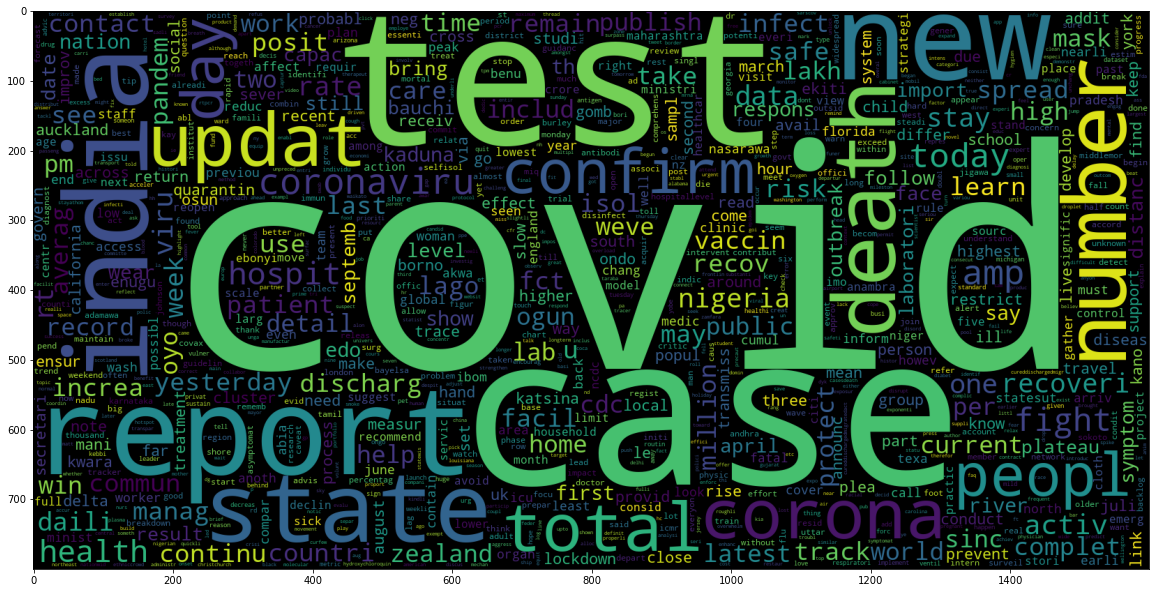

In [34]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(dataset[:3360].tweet))
plt.imshow(wc)

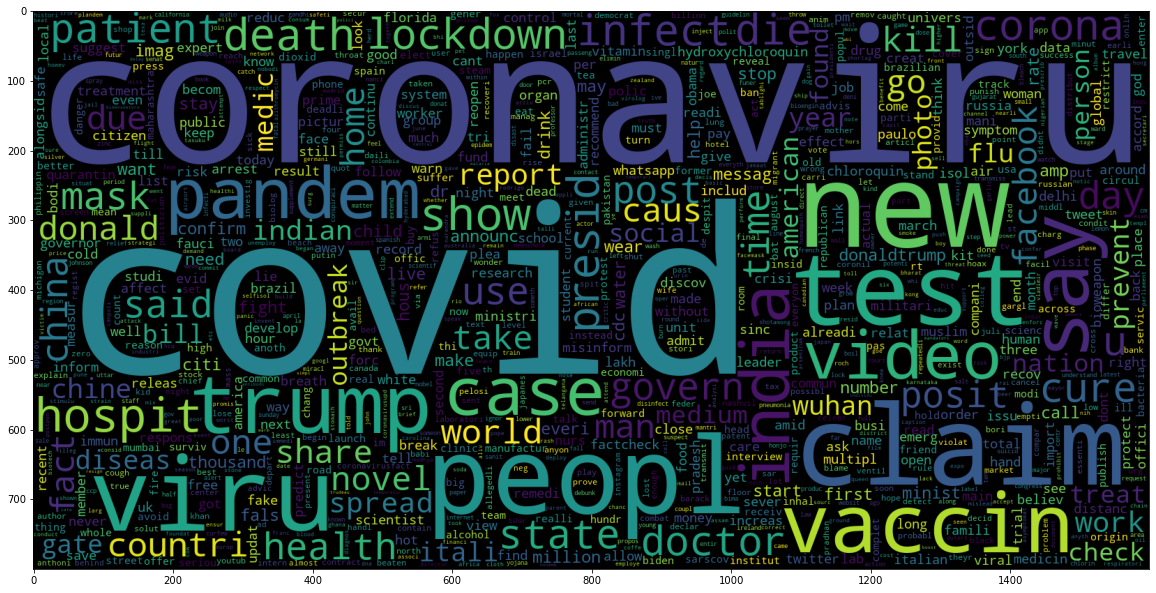

In [35]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(dataset[3360:].tweet))
plt.imshow(wc)

## Méthode Bag of words:

In [36]:
from gensim import corpora, models, similarities


In [37]:
target=pd.DataFrame()
target['tweet'] = dataset['tweet_tokenized'].apply(lambda x: " ".join(x))


In [38]:
# on supprimme les mots dont l'occurence est inférieur à 2
coun_vect = CountVectorizer(min_df=2)

In [39]:
# on vectorise tout les tweets de notre dataset par la methode bag of words 
count_matrix = coun_vect.fit_transform(target.tweet)
count_array = count_matrix.toarray()
# on enregistre les données dans une matrice puis sous format csv 
matrice = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names())
matrice.to_csv("matrice.csv",index=True,header=True)
matrice.head()

,aaj,aamir,aamp,ababa,abandon,abbott,abia,abil,abl,ableg,...,zee,zero,zika,zinc,zithromax,zombi,zone,zoo,zookeep,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#bow_vectors=matrice.values.tolist()

In [41]:
# on ajoute les vecteurs des tweets au dataset

#dataset['bow_vectors']=bow_vectors


In [42]:
#dataset.drop(columns=['bow_vectors'])

In [43]:
dataset.head()

,tweet,label,tweetsave,tweet_tokenized
0,cdc current report death gener discrep death c...,1,The CDC currently reports 99031 deaths. In gen...,"[cdc, current, report, death, gener, discrep, ..."
1,state report death small rise last tuesday sou...,1,States reported 1121 deaths a small rise from ...,"[state, report, death, small, rise, last, tues..."
3,india fight corona covid test laboratori india...,1,#IndiaFightsCorona: We have 1524 #COVID testin...,"[india, fight, corona, covid, test, laboratori..."
4,popul state gener larg case count look new cas...,1,Populous states can generate large case counts...,"[popul, state, gener, larg, case, count, look,..."
5,covid act found on averag person illinoi covid...,1,"Covid Act Now found ""on average each person in...","[covid, act, found, on, averag, person, illino..."


In [44]:
# la longueur de notre vocabulaire
vocab_size=len(coun_vect.vocabulary_)
vocab_size

4507

In [45]:
# on enregistre le vocabulaire dans une lite
vocab = list(coun_vect.vocabulary_.keys())


In [46]:
def vectorizetweet(text,vocab):
    d = dict()
    for word in vocab:
        d[word]=0
    for word in str(text).split():
        if word  in vocab:
            d[word]+=1
    return list(d.values())
dataset['bow_vectors']= dataset['tweet'].apply(lambda t: vectorizetweet(t,vocab))

In [47]:
dataset.to_csv("datasetfinal.csv",index=True,header=True)


## Division du dataset en données d'apprentissage, de test et de validation

 les données d'apprentissage représentent 80%

In [48]:
dataTrain, data_remaining, labelsTrain, label_remaining = train_test_split(dataset.bow_vectors,dataset.label,train_size=0.7)

on divise les données restantes en données test et données de validation

In [49]:
dataValid, dataTest, labelsValid, labelsTest = train_test_split(data_remaining, 
                                                                         label_remaining , 
                                                                         test_size=0.5)

In [50]:
print(dataTrain.shape,labelsTrain.shape)
print(dataValid.shape,labelsValid.shape)
print(dataTest.shape,labelsTest.shape)

(4494,) (4494,)
(963,) (963,)
(963,) (963,)


## Réseau de neurones

### Création de Pytorch Dataset

In [51]:
# Variable utiles 
BATCH_SIZE=32  #taille du batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #definition de la machine
device

device(type='cpu')

In [52]:
# Création d'une classe qui hérite de Dataset et redéfinit les méthodes comme susmentionné

class MyDataset(Dataset):
    def __init__(self, data,label):
        self.bow = data.tolist()
        self.targets = label.tolist()
    def __getitem__(self, i):
        return (
            self.bow[i],
            self.targets[i]
        )
    def __len__(self):
        return len(self.targets)

In [53]:
#Instanciation de 3 objets pour les données et labels de l'apprentissage, test et validation
train = MyDataset(dataTrain,labelsTrain)
test = MyDataset(dataTest,labelsTest)
valid = MyDataset(dataValid,labelsValid)

In [54]:
#réer les objets DataLoader pour les datasets d'apprentissage, test et validation en lui donner la taille du batch convenue
# la fonction collate permet de parcourir la listes des vecteurs
def collate(batch):
    bow = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    return  bow, target

trainDL = DataLoader(train,batch_size=BATCH_SIZE,shuffle = True,collate_fn=collate)
testDL = DataLoader(test,batch_size=BATCH_SIZE,shuffle = False,collate_fn=collate)
validDL = DataLoader(valid,batch_size=BATCH_SIZE,shuffle = False,collate_fn=collate)

### Création du réseau de neurones

- Input Layer : le vecteur bag of words
- Fonction d'activation  : ReLu
- Hidden layer  : applique une transformation linéaire sur les données en input, et réduit leur dimension en 50
- Fonction d'activation: Sigmoid
- Output Layer: applique une transformation linéaire sur les données en input, et réduit leur dimension en 2 
              2 résultats possibles : positif ou négatif
              probabilité que le document d'entrée soit classé comme l'étiquette

In [55]:
# taille des hidden layers 

HIDDEN1 = 50
#HIDDEN2 = 100





In [56]:
# Création d'une classe qui hérite de nn.Module et redéfinit le constructeur et la méthode forward
class MyNetwork(nn.Module):
    def __init__(self, device, vocab_size, hidden1, num_labels, batch_size):
        super(MyNetwork, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
      #  self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden1, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
      #  x = F.relu(self.fc2(x))

        return torch.sigmoid(self.fc3(x))

In [57]:
# instanciation de notre modele 
my_model = MyNetwork(
    vocab_size= vocab_size,
    hidden1=HIDDEN1,
   #     hidden2=HIDDEN2,

    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)


### Entraîner le réseau de neuronne

In [58]:
# TAUX D'APPRENTISSAGE
LEARNING_RATE = 0.001

In [59]:
#  la fonction du coût choisit est :  CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# la fonction d'optimisation choisit est : Adam
optimizer= optim.Adam(my_model.parameters(),lr=LEARNING_RATE)
# fct de changement du learning rate lors de chaque epoch 
scheduler = CosineAnnealingLR(optimizer, 1)

In [60]:
# fonction d'apprentissage
def train_epoch(model, optimizer, train_loader):
        model.train()
        total_loss, total = 0, 0
        for dt in trainDL:
            inputs,target = dt
 # Réinitialiser le gradient
            optimizer.zero_grad()
# Passe en avant

            output = model(torch.Tensor(inputs))
# Calculer le coût en comparant les labels prédits aux targets du minibatch
            loss = criterion(output, target)
# Faire la backpropagation
            loss.backward()
 # Effectuer un pas d'optimisation
            optimizer.step()
            #scheduler.step()
# Mettre à jour votre coût d'apprentissage en lui ajoutant le coût du data batch
            total_loss += loss.item()
            total += len(target)
#  la sortie est le coût moyen pour toutes les données training
        return total_loss / total
        
    
# fonction de validation
def validate_epoch(model, valid_loader):
    model.eval()
    total_loss, total = 0, 0
# Spécifier qu'on est sur le mode d'évaluation
    with torch.no_grad():
        for dt in trainDL:
            inputs,target = dt

            # Forward pass
            output = model(torch.Tensor(inputs))

            # Calculer le coût en comparant les labels prédits aux targets du minibatch
            loss = criterion(output, target)

            # Mettre à jour votre coût d'apprentissage en lui ajoutant le coût du data batch
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [61]:
import time
n_epochs = 10 # le nombre d'epochs est petit vu la taille du dataset.
# boucle sur les epochs:
start = time.time()
for i in range(n_epochs):
    train_loss = train_epoch(my_model, optimizer, trainDL)
    valid_loss = validate_epoch(my_model, validDL)
    
    tqdm.write(
        f'epoch #{i + 1:3d}\ttrain_loss: {train_loss:.2}\tvalid_loss: {valid_loss:.2}\n',
    )
stop = time.time()
print(f"Training time: {stop - start}s")
    
    

epoch #  1	train_loss: 0.018	valid_loss: 0.013

epoch #  2	train_loss: 0.013	valid_loss: 0.012

epoch #  3	train_loss: 0.012	valid_loss: 0.011

epoch #  4	train_loss: 0.011	valid_loss: 0.011

epoch #  5	train_loss: 0.011	valid_loss: 0.01

epoch #  6	train_loss: 0.01	valid_loss: 0.01

epoch #  7	train_loss: 0.01	valid_loss: 0.01

epoch #  8	train_loss: 0.01	valid_loss: 0.01

epoch #  9	train_loss: 0.01	valid_loss: 0.01

epoch # 10	train_loss: 0.01	valid_loss: 0.01

Training time: 26.461739540100098s


### Test du modèle

In [62]:
# Initilisation du  coût de test à 0

test_loss = 0

# Initialisation du  nombre de prévisions correctes à 0
correct = 0

y_true, y_pred = [], []

with torch.no_grad():
    
    for dt in validDL:
        inputs,target = dt
       # Forward pass
        output = my_model(torch.Tensor(inputs))
        probs= output
       # Calcul du  coût en comparant les labels prédits aux targets du minibatch
        loss = criterion(output, target)
        test_loss += loss.item()
        # On  compare le label prédit avec le labels du minibatch et on met à jour le nbre de prévisions correctes
        correct += torch.sum(torch.argmax(output, dim=1) == target).item()
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        y_true.extend(predictions)
        y_pred.extend(target)
        
        

    test_loss /= len(testDL)
# Calculer la précision: la moyenne des prévisions correctes sur l'ensemble des observations dans le dataset test
    correct /= len(testDL.dataset) #10.000  
print(f"Test loss {test_loss*100:.2f}%")

print(f"Accuracy {correct*100:.2f}%")
print(classification_report(y_true, y_pred))  

Test loss 39.88%
Accuracy 91.48%
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       446
           1       0.93      0.91      0.92       517

    accuracy                           0.91       963
   macro avg       0.91      0.91      0.91       963
weighted avg       0.91      0.91      0.91       963



## Déploiement du modele

In [63]:
l = list()
from IPython.core.display import display, HTML
def print_random_prediction(Testdataset,model, n=5):
    to_value = lambda x: 'True' if x else 'False'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            random_idx = random.randint(0,len(Testdataset)-1)
            print(random_idx)
            text, target, bow,tweet_tokenized =Testdataset.iloc[int(random_idx)]
            
            inputs = bow
            l=bow
            probs = model(torch.Tensor(inputs))
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs)
            print(probs)
            predicted = to_value(prediction)
            actual = to_value(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
    
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Tweet</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))
Testdataset=dataset[['tweetsave','label','bow_vectors','tweet_tokenized']].sample(100)
print_random_prediction(Testdataset,my_model, n=5)

48
[0.9957859  0.00385369]
68
[0.02346281 0.9753483 ]
0
[1.000000e+00 2.167119e-09]
83
[1.9138876e-07 9.9999988e-01]
64
[2.1560436e-06 9.9999785e-01]


### Exemple de prediction

In [64]:
## probleme ici 
def cleantweet(text):
    text = deEmojify(text)
    text = clean_hash(text)
    text = remove_mentions(text)
    text =  clean_url(text)
    text = text.lower()
    text = clean_stopword(text)
    text = clean_punctuation(text)
    text = clean_numbers(text)
    text = stemming(text)
    text = lemmatizing(text)
    return ''.join(map(str, text)) 


def vectorizetweet(text,vocab):
    d = dict()
    for word in vocab:
        d[word]=0
    for word in str(text).split():
        if word  in vocab:
            d[word]+=1
    return list(d.values())


def makeprediction(tweet_vector,model):
    model.eval()
    with torch.no_grad():
            probs = model(torch.Tensor(tweet_vector))
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs)
            print(probs)
            print(prediction)
    return prediction

In [65]:
text="RT @HHSGov: Looking for information about #COVID19 testing? Find the latest – including how to get a test in your community – on our update… 	"
tweet = cleantweet(text)
l2=vectorizetweet(tweet,vocab)
if makeprediction(l2,my_model)==0:
    print("false")
else: print("true")


[4.3602689e-04 9.9956185e-01]
1
true


### Enregistrement du model avec pickle

In [66]:
torch.save(my_model, "fakenews")